<a href="https://colab.research.google.com/github/kleineidam/LeafTransport/blob/main/ants.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
from matplotlib import pyplot as plt

# No memory

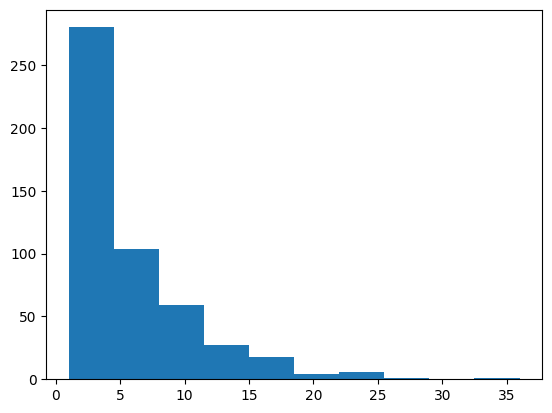

In [3]:
leaves = np.zeros(500)
leaf_moves = np.zeros_like(leaves)
for i in range(len(leaves)):
    for t in np.arange(100):
        #step forward
        leaves[i] += 1
        if np.random.randint(0,100) > 80:
            # DROP LEAF
            break

plt.hist(leaves);

# Memory

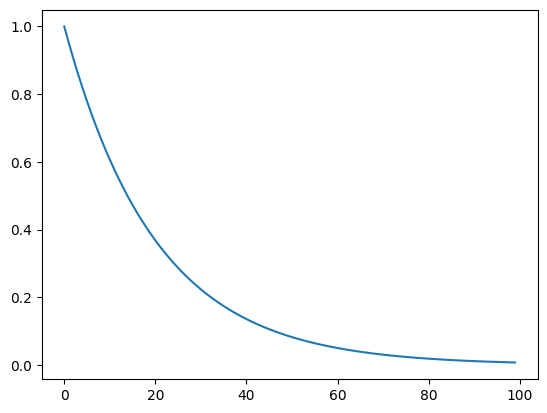

In [4]:
t = np.arange(100)
plt.plot(t, np.exp(-t/20))

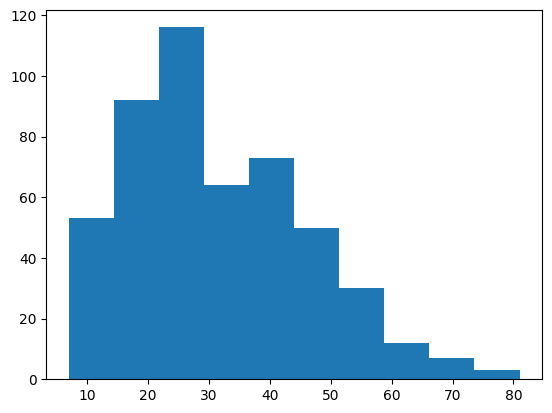

In [5]:
leaves = np.zeros(500)
for i in range(len(leaves)):

    for t in np.arange(100):
        #step forward
        leaves[i] += 1
        motivation = 100 * np.exp(-t/500)
        if np.random.randint(0,100) > motivation:
            # DROP LEAF
            break

plt.hist(leaves);

# Reuptake and memory

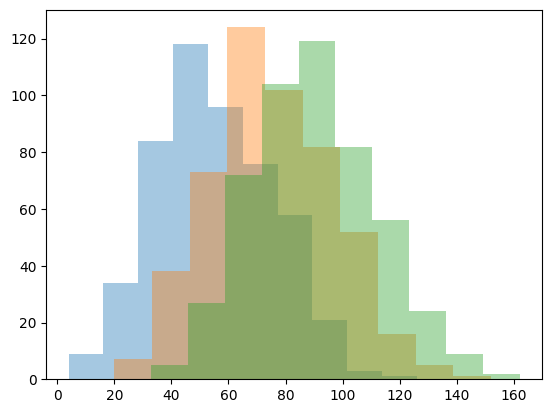

In [7]:
leaves = np.zeros(500)

leaf_moves = np.zeros_like(leaves)
for t in np.arange(1000):
    for i in range(len(leaves)):
        if leaf_moves[i]:
            #step forward
            leaves[i] += 1
            # demotivator
            motivation = 100 * np.exp(-t/500)
            if  motivation < np.random.randint(0,100):
                # DROP LEAF
                leaf_moves[i] = False
        else:
            if np.random.randint(0,100) > 95:
                leaf_moves[i] = True

    if t%300==299:
        plt.hist(leaves, alpha=0.4);
        #print(t)